In [1]:
# Inputs
input_file = "data/data-nh-vt.csv"
geohash_precision = 4
log_file = "run.log"
output_file = "output.geojson"
num_clusters = 2
use_cache = False
plot = True

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)


In [3]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.from_file(input_file)

In [4]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

In [5]:
from src.dataframes.geohash_species_counts import GeohashSpeciesCountsDataFrame

geohash_taxa_counts_dataframe = GeohashSpeciesCountsDataFrame.build(
    darwin_core_csv_lazy_frame, geohash_precision
)

In [6]:
from src.distance_matrix import DistanceMatrix

distance_matrix = DistanceMatrix.build(
    geohash_taxa_counts_dataframe,
    use_cache,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
from src.dataframes.geohash_cluster import GeohashClusterDataFrame

geohash_cluster_dataframe = GeohashClusterDataFrame.build(
    geohash_taxa_counts_dataframe,
    distance_matrix,
    num_clusters,
)

In [8]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors = ClusterColorDataFrame.from_clusters(geohash_cluster_dataframe)

In [9]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

all_stats = ClusterTaxaStatisticsDataFrame.build(
    geohash_taxa_counts_dataframe,
    geohash_cluster_dataframe,
    taxonomy_dataframe,
)

In [10]:
all_stats.df

cluster,kingdom,rank,name,count,average
u32,enum,enum,str,u32,f64
null,"""Protozoa""","""phylum""","""Mycetozoa""",1650,0.000094
null,"""Bacteria""","""phylum""","""Firmicutes""",78,0.000004
null,"""Bacteria""","""phylum""","""Desulfobacterota_I""",1,5.6998e-8
null,"""Bacteria""","""phylum""","""Acidobacteriota""",42,0.000002
null,"""Fungi""","""phylum""","""Entomophthoromycota""",47,0.000003
…,…,…,…,…,…
2,"""Animalia""","""species""","""Leucorrhinia glacialis""",96,0.000008
2,"""Plantae""","""species""","""Lappula squarrosa""",25,0.000002
2,"""Animalia""","""species""","""Poecile hudsonicus""",6504,0.000522


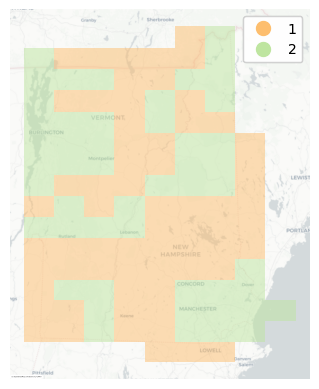

In [11]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters

feature_collection = build_geojson_feature_collection(
    geohash_cluster_dataframe,
    cluster_colors,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

# write_geojson(feature_collection, args.output_file)

In [12]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    geohash_cluster_dataframe,
    cluster_colors,
    all_stats,
)

display(HTML(html))


In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
)
X_tsne = tsne.fit_transform(distance_matrix.squareform())
tsne.kl_divergence_


0.35546839237213135

<Axes: >

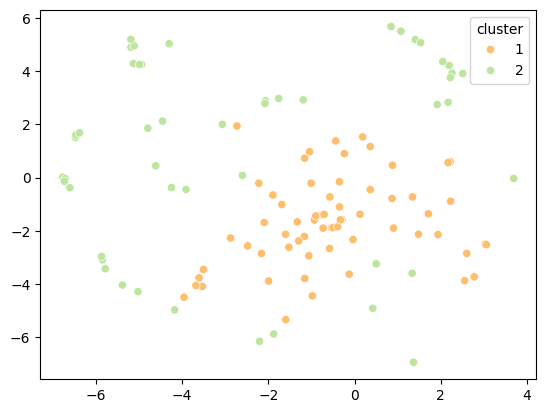

In [14]:
import seaborn as sns

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=geohash_cluster_dataframe.df["cluster"],
    palette=cluster_colors.to_dict(),
    alpha=1,
)

In [23]:
import polars as pl
from src.darwin_core import TaxonRank

notable_species = set()

for (cluster, geohashes) in geohash_cluster_dataframe.iter_clusters_and_geohashes():
    for kingdom, species, count, average in (
        all_stats.df
        .filter(
            pl.col("cluster") == cluster,
            pl.col("rank") == TaxonRank.species,
        )
        .sort(by="count", descending=True)
        .limit(20)
        .select(["kingdom", "name", "count", "average"])
        .iter_rows(named=False)
    ):
        all_average = (
            all_stats.df.filter(
                pl.col("kingdom") == kingdom,
                pl.col("name") == species,
                pl.col("cluster").is_null(),
                pl.col("rank") == TaxonRank.species,
            )
            .get_column("average")
            .item()
        )

        # If the difference between the average of the cluster and the average of all is greater than 50%, then it is notable
        percent_diff = (average / all_average * 100) - 100
        if abs(percent_diff) > 50:
            notable_species.add(species)

notable_species

{'Branta canadensis',
 'Cyanocitta cristata',
 'Junco hyemalis',
 'Leuconotopicus villosus',
 'Poecile atricapillus',
 'Sayornis phoebe',
 'Sitta canadensis',
 'Sitta carolinensis',
 'Spizella passerina',
 'Vireo olivaceus',
 'Zenaida macroura'}

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from scipy.cluster.hierarchy import linkage

linkage_array = linkage(distance_matrix.condensed(), "ward")

ordered_geohashes = geohash_taxa_counts_dataframe.ordered_geohashes()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geohash in ordered_geohashes:
    cluster = geohash_cluster_dataframe.cluster_for_geohash(geohash)
    col_colors.append(cluster_colors.get_color_for_cluster(cluster))

data = {}
for species in sorted(notable_species):
    counts = []

    for geohash in ordered_geohashes:
        geohash_counts_species = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash, pl.col("name") == species
        ).get_column("count").sum()
        geohash_counts_all = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash
        ).get_column("count").sum()
        geohash_average = geohash_counts_species / geohash_counts_all
        all_average = (
            all_stats.df.filter(
                pl.col("kingdom") == kingdom,
                pl.col("name") == species,
                pl.col("cluster").is_null(),
                pl.col("rank") == TaxonRank.species,
            )
            .get_column("average")
            .item()
        )
        counts.append(geohash_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


In [26]:
data

{'Branta canadensis': shape: (114,)
 Series: 'Branta canadensis' [f64]
 [
 	0.386146
 	0.506964
 	0.387442
 	0.212699
 	0.250235
 	…
 	0.0
 	0.366535
 	0.0
 	0.311511
 	0.36829
 ],
 'Cyanocitta cristata': shape: (114,)
 Series: 'Cyanocitta cristata' [f64]
 [
 	0.570306
 	0.523467
 	0.472928
 	0.3313
 	0.524145
 	…
 	0.129993
 	0.269421
 	0.0
 	0.275509
 	0.24854
 ],
 'Junco hyemalis': shape: (114,)
 Series: 'Junco hyemalis' [f64]
 [
 	0.154769
 	0.142999
 	0.142647
 	0.101725
 	0.133858
 	…
 	0.098765
 	0.078386
 	0.0
 	0.132927
 	0.172802
 ],
 'Leuconotopicus villosus': shape: (114,)
 Series: 'Leuconotopicus villosus' [f64]
 [
 	0.200802
 	0.152825
 	0.169414
 	0.124847
 	0.221378
 	…
 	0.0
 	0.110665
 	0.0
 	0.136512
 	0.119158
 ],
 'Poecile atricapillus': shape: (114,)
 Series: 'Poecile atricapillus' [f64]
 [
 	0.482465
 	0.4107
 	0.383466
 	0.314837
 	0.41861
 	…
 	0.092593
 	0.230172
 	1.0
 	0.238081
 	0.183713
 ],
 'Sayornis phoebe': shape: (114,)
 Series: 'Sayornis phoebe' [f64]

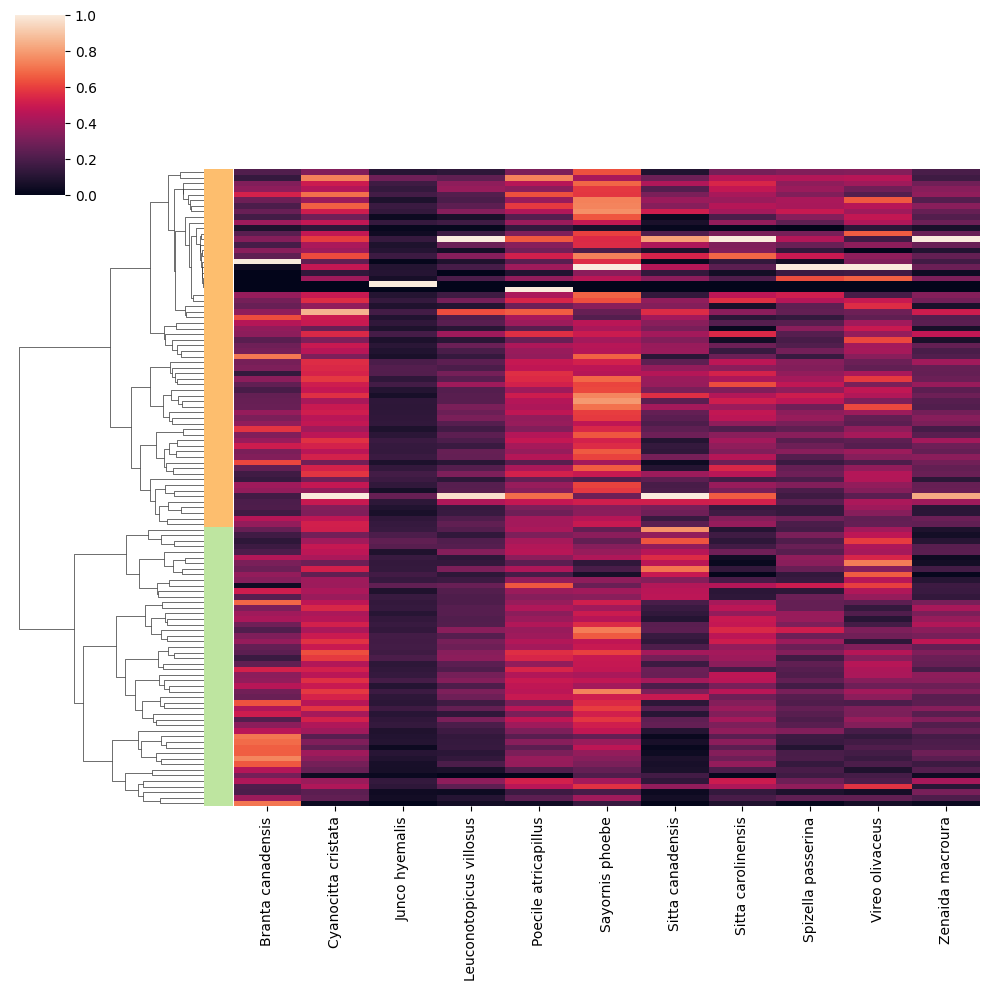

In [27]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)